In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Preprocessing Data

In [2]:
data_root = "../data/"
seed = 27

df = TabularDataset(data_root + "train_dataset.csv")
df = df.reset_index(drop=True)


df

,ID,pms_i_ymd,Area,Province,Shop Name,gender,date_of_birth_week,date_of_birth,marital_status,number_of_children,...,Mortgage_balance,Credit Card_balance,Automobile installment purchase_balance,Other installment purchase_balance,Loan for agriculture_balance,Other Loans_balance,Bank inquiry_count,Consumer finance inquiry_count,Leasing enquiry_count,default_12month
0,202412000001,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1971/5/18,1,2,...,0.0,0.0,0.0,0.0,30000.0,0.0,12,6,0,0
1,202412000002,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,4,1983/1/5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,202412000003,2018/4/3,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1992/11/19,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0,0
3,202412000004,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1990/11/3,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,202412000005,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1994/12/16,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32519,202412049586,2018/8/31,webpak,webpak,webpak,F2,3,1995/10/24,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
32520,202412049587,2018/8/31,webpak,webpak,webpak,F2,3,1979/3/30,1,0,...,0.0,0.0,267504.0,0.0,0.0,0.0,0,0,0,0
32521,202412049588,2018/8/31,webpak,webpak,webpak,M,2,1992/5/11,1,0,...,0.0,0.0,0.0,65780.0,0.0,0.0,0,1,0,0
32522,202412049589,2018/8/31,webpak,webpak,webpak,M,2,1989/6/12,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,1,0


In [3]:
# print(df.iloc[:2].to_json(orient='records'))

## Train data

In [4]:
def safe_division(numerator, denominator, default=0):
  """Safe division handling division by zero"""
  return np.where(denominator != 0, numerator / denominator, default)


def drop_columns(df):
  """Drop unnecessary columns"""
  drop_columns = [
    "ID",
    "r_generalcode1",
    "r_generalcode2",
    "r_generalcode4",
    "r_generalcode5",
  ]

  return df.drop(columns=drop_columns)


def handle_missing_values(df):
  """Handle missing values with appropriate strategies"""
  df = df.copy()

  # Simple zero imputation for income
  df["r_additional_income"] = df["r_additional_income"].fillna(0)
  df["r_spouse_income"] = df["r_spouse_income"].fillna(0)

  # Business type specific imputation for credit limit
  df["r_expected_credit_limit"] = df.groupby("c_business_type")["r_expected_credit_limit"].transform(
    lambda x: x.fillna(x.median())
  )

  # Mode imputation for categorical
  df["r_generalcode3"] = df["r_generalcode3"].fillna(4)
  df["r_propose"] = df["r_propose"].fillna(6)  # less than 1.5% missing fill other category
  df["c_date_of_salary_payment"] = df["c_date_of_salary_payment"].fillna(1)  # less than 1% missing

  return df


def calculate_age(df):
  """Calculate age from date of birth"""
  df = df.copy()
  df["date_of_birth"] = pd.to_datetime(df["date_of_birth"])
  reference_date = pd.to_datetime("2024-01-01")
  df["age"] = (reference_date - df["date_of_birth"]).dt.days // 365

  df["pms_i_ymd"] = pd.to_datetime(df["pms_i_ymd"])
  # Create age at application
  df["age_application"] = (df["pms_i_ymd"] - df["date_of_birth"]).dt.days // 365

  return df.drop(["date_of_birth", "pms_i_ymd"], axis=1)


def calculate_income_features(df):
  """Calculate income-related features"""
  df = df.copy()

  # Basic income calculations
  df["total_income"] = df["c_monthly_salary"] + df["r_additional_income"]

  # df["income_per_dependent"] = safe_division(df["total_income"], (df["number_of_children"] + 1))
  # df["income_per_resident"] = safe_division(df["total_income"], df["number_of_resident"])

  # Drop original columns
  df = df.drop(columns=["c_monthly_salary", "r_additional_income"])

  return df


def calculate_stability_features(df):
  """Calculate stability-related features"""
  df = df.copy()

  # Employment stability
  df["employment_months"] = df["c_number_of_working_year"] * 12 + df["c_number_of_working_month"]
  df["job_stability_score"] = safe_division(df["employment_months"], df["age"], default=0).clip(max=1, min=0)

  # Living stability with minimum thresholds
  df["living_months"] = df["living_period_year"] * 12 + df["living_period_month"]
  df["residence_stability_score"] = safe_division(df["living_months"], df["age"], default=0).clip(max=1, min=0)

  # Drop original columns
  df = df.drop(
    columns=[
      "c_number_of_working_year",
      "c_number_of_working_month",
      "living_period_year",
      "living_period_month",
    ]
  )

  return df


def calculate_risk_features(df):
  """Calculate risk-related features"""
  df = df.copy()

  # Credit inquiries
  df["total_inquiries"] = df[["Bank inquiry_count", "Consumer finance inquiry_count", "Leasing enquiry_count"]].sum(
    axis=1
  )
  # df["total_inquiries"] = df["Bank inquiry_count"] + df["Consumer finance inquiry_count"]
  # Debt metrics
  df["debt_burden"] = safe_division(df["r_allloan_amount"], (df["total_income"] * 12))
  df["credit_limit_ratio"] = safe_division(df["r_expected_credit_limit"], df["total_income"])
  # )

  return df


def calculate_debt_profile(df):
  """Calculate comprehensive debt profile features"""
  df = df.copy()

  # Total debt exposure
  df["total_debt"] = (
    df["Overdraft_balance"]
    + df["Personal Loan_balance"]
    + df["Mortgage_balance"]
    + df["Credit Card_balance"]
    + df["Automobile installment purchase_balance"]
    + df["Other installment purchase_balance"]
    + df["Loan for agriculture_balance"]
    + df["Other Loans_balance"]
  )

  # Debt diversity score
  df["debt_products_count"] = (
    (df["Overdraft_count"] > 0).astype(int)
    + (df["Personal Loan_count"] > 0).astype(int)
    + (df["Mortgage_count"] > 0).astype(int)
    + (df["Credit Card_count"] > 0).astype(int)
    + (df["Automobile installment purchase_count"] > 0).astype(int)
  )

  # Average debt per product
  df["avg_debt_per_product"] = safe_division(df["total_debt"], df["debt_products_count"])

  return df


def calculate_purpose_features(df):
  """Calculate features related to loan purpose and intent"""
  df = df.copy()

  # Combine expected credit limit with purpose
  df["credit_purpose_ratio"] = safe_division(
    df["r_expected_credit_limit"], df["r_propose"].map(df.groupby("r_propose")["r_expected_credit_limit"].median())
  )

  return df


def define_data_type(df):
  """Define data types for each column"""
  df = df.copy()

  int_cols = ["Leasing enquiry_count", "Bank inquiry_count", "Consumer finance inquiry_count"]

  for col in int_cols:
    if col in df.columns:
      if col == "Leasing enquiry_count":
        df[col] = df[col].replace("*", -1)
      df[col] = df[col].astype("int")

  category_cols = [
    "Area",
    "Province",
    "postal_code",
    "r_propose",
    "Shop Name",
    "apply",
    "c_postal_code",
    "c_business_type",
    "c_employment_status",
    "c_occupation",
    "c_position",
    "c_salary_payment_methods",
    "c_date_of_salary_payment",
    "date_of_birth_week",
    "gender",
    "marital_status",
    "media",
    "r_generalcode1",
    "r_generalcode2",
    "r_generalcode3",
    "r_generalcode4",
    "r_generalcode5",
    "tel_category",
    "type_of_residence",
  ]
  for col in category_cols:
    if col in df.columns:
      df[col] = df[col].astype("category")

  return df


def preprocess(df):
  """Main preprocessing pipeline"""
  df = df.copy()

  # Basic preprocessing
  df = drop_columns(df)
  df = handle_missing_values(df)
  df.fillna(0, inplace=True)
  df = define_data_type(df)

  # Feature engineering
  df = calculate_age(df)
  df = calculate_income_features(df)
  df = calculate_stability_features(df)
  df = calculate_risk_features(df)
  df = calculate_debt_profile(df)
  df = calculate_purpose_features(df)
  
  # denoise
  for col in df.select_dtypes(include=['float64']).columns:
    df[col] = np.floor(df[col] * 100) / 100

  return df

In [5]:
data = preprocess(df)

# Merge with original features
data["y"] = data["default_12month"].astype("int")
data = data.drop(columns=["default_12month"])
data = data.reset_index(drop=True)

# pd.set_option('display.max_columns', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32524 entries, 0 to 32523
Data columns (total 62 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Area                                     32524 non-null  category
 1   Province                                 32524 non-null  category
 2   Shop Name                                32524 non-null  category
 3   gender                                   32524 non-null  category
 4   date_of_birth_week                       32524 non-null  category
 5   marital_status                           32524 non-null  category
 6   number_of_children                       32524 non-null  int64   
 7   postal_code                              32524 non-null  category
 8   tel_category                             32524 non-null  category
 9   number_of_resident                       32524 non-null  int64   
 10  type_of_residence                 

/tmp/ipykernel_1508392/2748305361.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["r_expected_credit_limit"], df["r_propose"].map(df.groupby("r_propose")["r_expected_credit_limit"].median())


In [6]:
from sklearn.model_selection import train_test_split

test_size = 0.2
train_data, test_data = train_test_split(data, test_size=test_size, random_state=seed, stratify=data["y"])

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_data

,Area,Province,Shop Name,gender,date_of_birth_week,marital_status,number_of_children,postal_code,tel_category,number_of_resident,...,living_months,residence_stability_score,total_inquiries,debt_burden,credit_limit_ratio,total_debt,debt_products_count,avg_debt_per_product,credit_purpose_ratio,y
0,Central,Kamphaeng Phet,Big C Kamphaeng Phet,M,6,1,0,62110,3,4,...,240,1.00,18,0.85,2.05,170945.0,2,85472.50,1.00,1
1,Bangkok Metropolitan Region,Nonthaburi,Robinson Srisamarn,F2,3,5,1,10210,3,1,...,156,1.00,28,0.00,0.93,38769.0,1,38769.00,0.60,0
2,East,Chon Buri,Habor Mall Laem Chabang Chon Buri,F1,4,2,2,20230,3,2,...,14,0.36,10,0.07,1.88,82301.0,2,41150.50,1.00,0
3,Central,Saraburi,Robinson Saraburi,M,4,1,0,18140,3,7,...,384,1.00,5,0.06,1.15,233844.0,2,116922.00,0.50,1
4,Central,Saraburi,Robinson Saraburi,M,1,2,2,13130,3,7,...,120,1.00,1,0.00,1.80,0.0,0,0.00,0.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26014,Bangkok Metropolitan Region,Bangkok,Seacon Square,F2,5,2,1,10250,3,5,...,312,1.00,13,0.17,1.30,86220.0,2,43110.00,1.25,1
26015,Northeast,Nakhon Ratchasima,The Mall Korat,M,2,5,2,30210,3,3,...,400,1.00,2,0.09,1.17,28073.0,1,28073.00,0.75,0
26016,North,Phrae,Big C Phrae,F2,5,1,1,54000,3,4,...,312,1.00,10,0.19,1.18,614951.0,3,204983.66,0.75,0
26017,Bangkok Metropolitan Region,Samut Prakan,Big C Bangphli,F2,2,5,1,10540,3,2,...,6,0.13,17,0.11,1.03,85429.0,2,42714.50,0.75,0


In [7]:
data["y"].value_counts(normalize=True)

y
0    0.870496
1    0.129504
Name: proportion, dtype: float64

In [8]:
test = TabularDataset(data_root + "public_dataset_without_gt.csv")
test = preprocess(test)

test

/tmp/ipykernel_1508392/2748305361.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["r_expected_credit_limit"], df["r_propose"].map(df.groupby("r_propose")["r_expected_credit_limit"].median())


,Area,Province,Shop Name,gender,date_of_birth_week,marital_status,number_of_children,postal_code,tel_category,number_of_resident,...,job_stability_score,living_months,residence_stability_score,total_inquiries,debt_burden,credit_limit_ratio,total_debt,debt_products_count,avg_debt_per_product,credit_purpose_ratio
0,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,2,2,2,10120,3,4,...,0.02,108,1.00,4,0.00,0.69,0.0,0,0.0,0.25
1,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,2,2,0,10120,3,5,...,0.76,38,1.00,12,0.13,0.83,50671.0,2,25335.5,0.50
2,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,4,1,0,10120,3,1,...,0.06,24,0.51,5,0.16,2.27,12653.0,1,12653.0,1.00
3,Bangkok Metropolitan Region,Bangkok,Silom Complex,F1,5,3,3,10530,3,6,...,1.00,120,1.00,15,0.16,1.98,51734.0,1,51734.0,2.50
4,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,2,2,2,10700,3,5,...,0.45,16,0.45,0,0.00,0.73,0.0,0,0.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6562,webpak,webpak,webpak,F2,7,2,1,20230,3,2,...,0.31,27,0.71,3,0.00,4.95,6351.0,1,6351.0,2.70
6563,webpak,webpak,webpak,F2,1,1,0,20230,3,1,...,0.70,26,0.86,7,0.00,0.00,7128.0,1,7128.0,0.00
6564,webpak,webpak,webpak,M,5,2,0,21140,3,4,...,0.44,62,1.00,0,0.00,4.90,158000.0,0,0.0,1.70
6565,webpak,webpak,webpak,F2,3,1,0,20000,3,1,...,1.00,67,1.00,5,0.00,0.98,695451.0,2,347725.5,0.70


# Train

In [ ]:
ensemble_kwargs = {
  "stack_ensemble_levels": 2,  # Number of stacking levels
  "ensemble_type": "weighted",  # Use weighted ensemble
}

# Model hyperparameters with ensemble settings
hyperparameters = {
  "AG_ARGS": ensemble_kwargs,
}

In [ ]:
preset = [
  "best_quality",
  "high_quality",
  "good_quality",
  "experimental_quality",
  "medium_quality",
  "optimize_for_deployment",
][3]

included_model_types = ["XGB", "GMB", "RF", "FT_TRANSFORMER"]
# excluded_model_types = ["KNN", "NN_TORCH", "CAT"]
# problem_type = "regression"
problem_type = "binary"


eval_metric = ["roc_auc", "f1", "average_precision"]

time_limit = 90 * 60
predictor = TabularPredictor(
  label="y",
  verbosity=2,
  problem_type=problem_type,
  eval_metric=eval_metric[0],
  # sample_weight="balance_weight",  # "auto_weight"
).fit(
  train_data=train_data,
  num_gpus=1,
  # test_data=test_data,
  presets=preset,
  time_limit=time_limit,
  num_bag_folds=5,  # Use 5-fold cross-validation
  # included_model_types=included_model_types,
  # excluded_model_types=excluded_model_types,
  # num_stack_levels=4,  # Use 4-layer stack ensemble
  # refit_full=True,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241208_085101"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Nov 5 00:21:55 UTC 2024
CPU Count:          12
Memory Avail:       17.80 GB / 23.47 GB (75.8%)
Disk Space Avail:   878.22 GB / 1006.85 GB (87.2%)
Presets specified: ['experimental_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on s

# load model

In [10]:
model_path = "./AutogluonModels/ag-20241207_200837"
predictor = TabularPredictor.load(model_path)

# Prediction and Evaluation

In [12]:
# test on train data
top = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                               model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0                WeightedEnsemble_L2   0.655839     roc_auc       2.648090  184.621256                0.002421           1.308991            2      False         20
1               CatBoost_r177_BAG_L1   0.648683     roc_auc       0.147631   19.655854                0.147631          19.655854            1      False         11
2                 CatBoost_r9_BAG_L1   0.648534     roc_auc       0.174927   36.643816                0.174927          36.643816            1      False         14
3               CatBoost_r137_BAG_L1   0.647010     roc_auc       0.138497   38.290071                0.138497          38.290071            1      False         18
4                    CatBoost_BAG_L1   0.645776     roc_auc       0.169914   59.993143                0.169914   

In [13]:
# test on eval
predictor.leaderboard(test_data, silent=True, extra_info=True, extra_metrics=eval_metric).head(6)
# predictor.model_names()

,model,score_test,roc_auc,f1,average_precision,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,...,hyperparameters,hyperparameters_fit,ag_args_fit,features,compile_time,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
0,XGBoost_r49_BAG_L2,0.662554,0.662554,0.0,0.212236,0.632802,roc_auc,2.029330,13.398676,487.589784,...,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[type_of_residence, XGBoost_r49_BAG_L1, Random...",None,"{'n_estimators': 10000, 'learning_rate': 0.038...",{'n_estimators': 57},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[XGBoost_r33_BAG_L1, XGBoost_r49_BAG_L1, Rando...",[]
1,XGBoost_r22_BAG_L2,0.661727,0.661727,0.0,0.212171,0.634121,roc_auc,2.032727,12.857611,478.722807,...,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[type_of_residence, XGBoost_r49_BAG_L1, Random...",None,"{'n_estimators': 10000, 'learning_rate': 0.077...",{'n_estimators': 30},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[XGBoost_r33_BAG_L1, XGBoost_r49_BAG_L1, Rando...",[]
2,XGBoost_r31_BAG_L2,0.661225,0.661225,0.0,0.212961,0.638027,roc_auc,2.045992,12.921141,513.456190,...,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[type_of_residence, XGBoost_r49_BAG_L1, Random...",None,"{'n_estimators': 10000, 'learning_rate': 0.009...",{'n_estimators': 284},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[XGBoost_r33_BAG_L1, XGBoost_r49_BAG_L1, Rando...",[]
3,XGBoost_r95_BAG_L2,0.660982,0.660982,0.0,0.211794,0.634912,roc_auc,2.024949,12.749050,458.204671,...,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[type_of_residence, XGBoost_r49_BAG_L1, Random...",None,"{'n_estimators': 10000, 'learning_rate': 0.066...",{'n_estimators': 35},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[XGBoost_r33_BAG_L1, XGBoost_r49_BAG_L1, Rando...",[]
4,WeightedEnsemble_L3,0.660546,0.660546,0.0,0.216430,0.645019,roc_auc,0.869170,6.368026,222.846527,...,"{'use_orig_features': False, 'valid_stacker': ...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[RandomForest_r15_BAG_L1, XGBoost_r49_BAG_L1, ...",None,"{'ensemble_size': 25, 'subsample_size': 1000000}",{'ensemble_size': 14},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[RandomForest_r15_BAG_L1, XGBoost_r49_BAG_L1, ...",[]
5,WeightedEnsemble_L2,0.660546,0.660546,0.0,0.216430,0.645019,roc_auc,0.869292,6.368171,222.843779,...,"{'use_orig_features': False, 'valid_stacker': ...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[RandomForest_r15_BAG_L1, XGBoost_r49_BAG_L1, ...",None,"{'ensemble_size': 25, 'subsample_size': 1000000}",{'ensemble_size': 14},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[RandomForest_r15_BAG_L1, XGBoost_r49_BAG_L1, ...",[]


In [14]:
# model_name = "WeightedEnsemble_L2"  # predictor.model_names()[0]
# model_name = "RandomForestGini_BAG_L1_FULL"
# model_name = "CatBoost_BAG_L1"
# model_name = "RandomForestEntr_BAG_L2_FULL"
# model_name = "CatBoost_r13_BAG_L2"
model_name = "XGBoost_r49_BAG_L2"

## For regression

In [10]:
y_test = predictor.predict(test_data, model=model_name)
perf = predictor.evaluate_predictions(y_true=test_data["y"], y_pred=y_test, auxiliary_metrics=True)
perf, y_test.hist()

AssertionError: `evaluate_predictions` requires y_pred_proba input when evaluating "roc_auc"... Please generate valid input via `predictor.predict_proba(data)`.
This may have occurred if you passed in predict input instead of predict_proba input, or if you specified `as_multiclass=False` to `predictor.predict_proba(data, as_multiclass=False)`, which is not supported by `evaluate_predictions`.

In [ ]:
auc_score = roc_auc_score(test_data["y"], y_test)
print(f"AUC Score: {auc_score}")

fpr, tpr, thresholds = roc_curve(test_data["y"], y_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.show()

NameError: name 'y_test' is not defined

In [ ]:
def eval_auc(test_data):
  global predictor
  model_names = predictor.model_names()

  y_test = test_data["y"]
  test_data_nolab = test_data.drop(columns=["y"])
  auc_roc_scores = {}
  for model_name in model_names:
    try:
      y_pred = predictor.predict(test_data_nolab, model=model_name)
    except Exception as e:
      print(f"Model {model_name} does not support predict method : {e}")
      continue
    auc_roc = roc_auc_score(y_test, y_pred)
    auc_roc_scores[model_name] = auc_roc

  top = pd.DataFrame.from_dict(auc_roc_scores, orient="index", columns=["AUC-ROC"])
  top = top.sort_values(by=["AUC-ROC"], ascending=False)
  return top

In [30]:
eval_auc(test_data)

Model LightGBMXT_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBM_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model CatBoost_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model NeuralNetFastAI_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'dls'
Model XGBoost_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'set_params'
Model NeuralNetTorch_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBMLarge_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model CatBoost_r177_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model NeuralNetTorch_r79_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBM_r131_BAG_L1 does not support predict method

,AUC-ROC
CatBoost_BAG_L1_FULL,0.672644
CatBoost_r137_BAG_L1_FULL,0.669088
WeightedEnsemble_L2_FULL,0.668789
WeightedEnsemble_L3_FULL,0.668568
CatBoost_r9_BAG_L2_FULL,0.667053
CatBoost_BAG_L2_FULL,0.666182
CatBoost_r177_BAG_L1_FULL,0.666125
CatBoost_r177_BAG_L2_FULL,0.665734
CatBoost_r13_BAG_L1_FULL,0.663764
CatBoost_r9_BAG_L1_FULL,0.662387


In [21]:
pred = predictor.predict(test, model=model_name)
pred

NameError: name 'predictor' is not defined

## For Binary

/root/miniforge3/envs/ag/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 {'roc_auc': 0.6625544277707148,
  'accuracy': 0.8705611068408916,
  'balanced_accuracy': 0.5,
  'mcc': 0.0,
  'f1': 0.0,
  'precision': 0.0,
  'recall': 0.0})

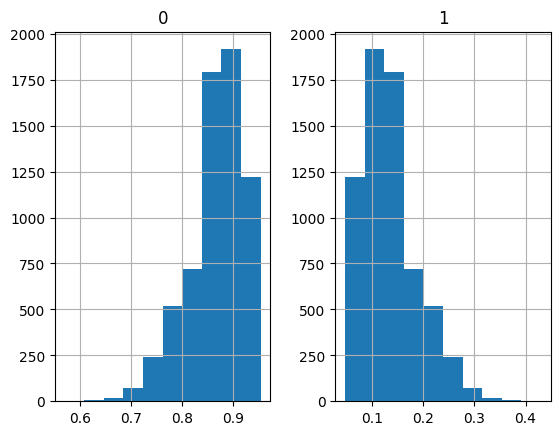

In [15]:
y_test = predictor.predict_proba(test_data, model=model_name)
perf = predictor.evaluate_predictions(y_true=test_data["y"], y_pred=y_test, auxiliary_metrics=True)
y_test.hist(), perf

AUC Score: 0.6625544277707148


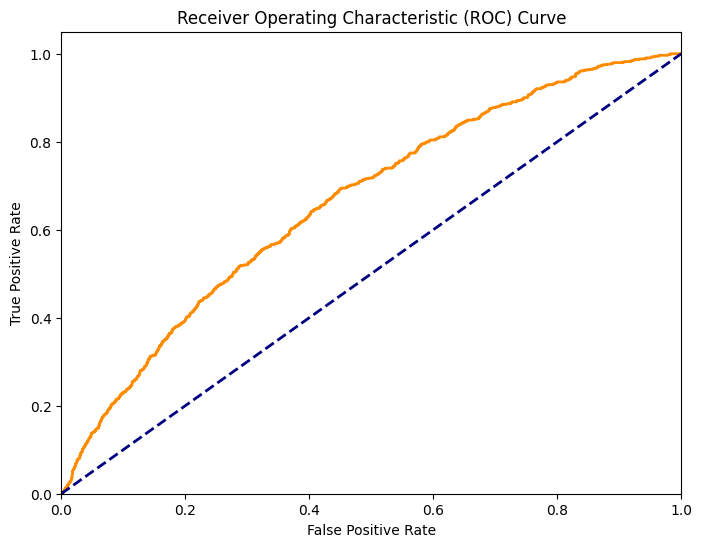

In [16]:
auc_score = roc_auc_score(test_data["y"], y_test[1])
print(f"AUC Score: {auc_score}")

fpr, tpr, thresholds = roc_curve(test_data["y"], y_test[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.show()

In [17]:
pred = predictor.predict_proba(test, model=model_name)[1]
pred

0       0.346393
1       0.087636
2       0.161829
3       0.095250
4       0.155120
          ...   
6562    0.127700
6563    0.197851
6564    0.106569
6565    0.107811
6566    0.142067
Name: 1, Length: 6567, dtype: float64

##### Merge 2 models with different index

In [ ]:
old_pred = pd.read_csv("not_zero.csv", index_col=0)
old_pred

pred = pd.read_csv("zero.csv", index_col=0)
pred

# Create a new series with all unique indices
all_indices = sorted(set(old_pred.index) | set(pred.index))
new_pred = pd.Series(index=all_indices, dtype=float)

# Fill in values from old predictions
for index, row in old_pred.iterrows():
  new_pred[index] = row["1"]

for index, row in pred.iterrows():
  new_pred[index] = row["1"]
new_pred
pred = new_pred

## Feature

In [46]:
predictor.feature_importance(test_data, subsample_size=1000)

Computing feature importance via permutation shuffling for 66 features using 1000 rows with 5 shuffle sets...


	334.02s	= Expected runtime (66.8s per shuffle set)
	76.95s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Leasing enquiry_count,0.011697,0.003955,0.001355,5,0.019841,0.003554
Overdraft_balance,0.009627,0.010077,0.049749,5,0.030376,-0.011121
income_per_dependent,0.007857,0.006765,0.030121,5,0.021786,-0.006073
job_stability_score,0.005591,0.009087,0.120442,5,0.024302,-0.013119
number_of_children,0.005505,0.006544,0.066557,5,0.018979,-0.007969
...,...,...,...,...,...,...
Overdraft_count,-0.000629,0.001683,0.774716,5,0.002836,-0.004093
number_of_resident,-0.000640,0.001365,0.823020,5,0.002172,-0.003451
gender,-0.001443,0.005992,0.690649,5,0.010894,-0.013781
r_generalcode3,-0.001730,0.006178,0.717413,5,0.010991,-0.014451


In [38]:
important_feature = predictor.feature_importance(test_data, subsample_size=1000)
important_feature.head(5), important_feature.tail(5)

Computing feature importance via permutation shuffling for 66 features using 1000 rows with 5 shuffle sets...
	304.99s	= Expected runtime (61.0s per shuffle set)
	80.14s	= Actual runtime (Completed 5 of 5 shuffle sets)


(                                    importance    stddev   p_value  n  \
 Leasing enquiry_count                 0.010030  0.003470  0.001475  5   
 Overdraft_balance                     0.007573  0.007512  0.043618  5   
 Other installment purchase_balance    0.005257  0.003028  0.008907  5   
 income_per_dependent                  0.005161  0.007368  0.096158  5   
 Shop Name                             0.005136  0.003494  0.015152  5   
 
                                     p99_high   p99_low  
 Leasing enquiry_count               0.017175  0.002886  
 Overdraft_balance                   0.023041 -0.007894  
 Other installment purchase_balance  0.011491 -0.000978  
 income_per_dependent                0.020333 -0.010010  
 Shop Name                           0.012330 -0.002058  ,
                      importance    stddev   p_value  n  p99_high   p99_low
 Credit Card_balance   -0.000506  0.001295  0.784100  5  0.002160 -0.003172
 postal_code           -0.000875  0.001375  0.886133 

# Submit

(<Axes: >, <Axes: >)

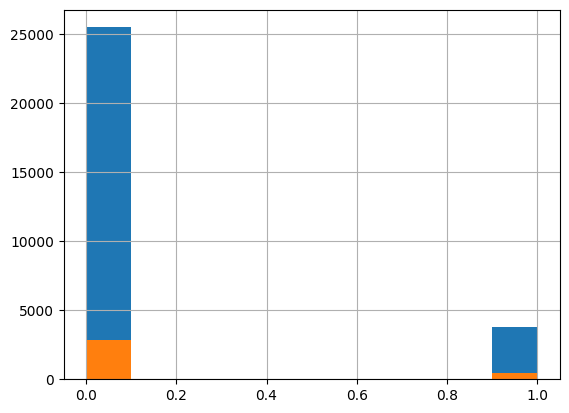

In [18]:
train_data["y"].hist(), test_data["y"].hist()

<Axes: >

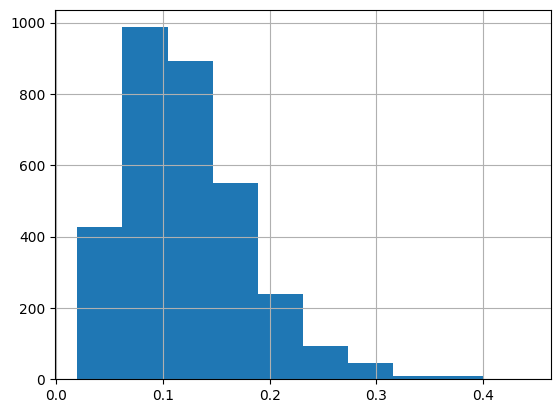

In [19]:
y_test[1].hist()

<Axes: >

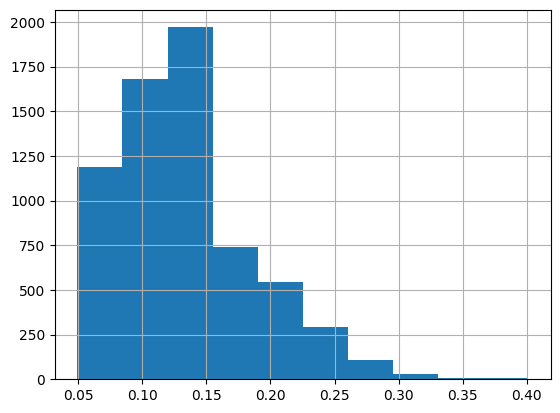

In [20]:
pred.hist()

In [18]:
sub = pd.read_csv(data_root + "submission_template_for_public.csv")
# sub = sub[['no']]
sub

,ID,default_12month
0,2.024120e+11,0
1,2.024120e+11,0
2,2.024120e+11,0
3,2.024120e+11,0
4,2.024120e+11,0
...,...,...
6562,2.024120e+11,0
6563,2.024120e+11,0
6564,2.024120e+11,0
6565,2.024120e+11,0


In [19]:
sub["default_12month"] = pred
sub

,ID,default_12month
0,2.024120e+11,0.346393
1,2.024120e+11,0.087636
2,2.024120e+11,0.161829
3,2.024120e+11,0.095250
4,2.024120e+11,0.155120
...,...,...
6562,2.024120e+11,0.127700
6563,2.024120e+11,0.197851
6564,2.024120e+11,0.106569
6565,2.024120e+11,0.107811


In [ ]:
sub.to_csv(f"come_{problem_type}_{test_size}_{model_name}.csv", index=False)
# sub.to_csv(".csv", index=False)

In [35]:
import os

model_names = predictor.model_names()

save_path = "submission/"
os.makedirs(save_path, exist_ok=True)

for model_name in model_names:
  try:
    # pred = predictor.predict(test, model=model_name)
    pred = predictor.predict_proba(test, model=model_name)[1]
  except:
    print(f"Model {model_name} does not support predict method")
    continue
  # Compute AUC-ROC

  sub["default_12month"] = pred
  sub.to_csv(f"{save_path}99_{model_name}.csv", index=False)